<a href="https://colab.research.google.com/github/shamburgularara/Ideathon-Protocol/blob/main/Lu_isa_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from _static.common.helpers import setup_hardware_client
setup_hardware_client()

ModuleNotFoundError: No module named '_static'

## Environment variables

In [ ]:
# loads default neuron parameters
from _static.common.helpers import get_nightly_calibration
calib = get_nightly_calibration()

In [ ]:
%matplotlib inline
import numpy as np
import ipywidgets as w
import matplotlib.pyplot as plt
from contextlib import suppress
with suppress(IOError):
    plt.style.use("_static/matplotlibrc")

import pynn_brainscales.brainscales2 as pynn
np.random.seed(1234)

from pynn_brainscales.brainscales2 import Population
from pynn_brainscales.brainscales2.standardmodels.cells import SpikeSourceArray
from pynn_brainscales.brainscales2.standardmodels.synapses import StaticSynapse

## Helper functions

In [ ]:
# Plotting

def plot_membrane_dynamics(population: Population, segment_id=-1, ylim=None):
    """
    Plot the membrane potential of the neuron in a given population view. Only
    population views of size 1 are supported.
    :param population: Population, membrane traces and spikes are plotted for.
    :param segment_id: Index of the neo segment to be plotted. Defaults to
                       -1, encoding the last recorded segment.
    :param ylim: y-axis limits for the plot.
    """
    if len(population) != 1:
        raise ValueError("Plotting is supported for populations of size 1.")
    # Experimental results are given in the 'neo' data format
    mem_v = population.get_data("v").segments[segment_id].irregularlysampledsignals[0]

    plt.plot(mem_v.times, mem_v, alpha=0.5)
    print(f"Mean membrane potential: {mem_v.mean()}")
    plt.xlabel("Wall clock time [ms]")
    plt.ylabel("ADC readout [a.u.]")
    if ylim:
        plt.ylim(ylim)

## Define the network

In [ ]:
# setup PyNN and inect calibration data (loads calibration into PyNN - initalises eveyrhting)
pynn.setup(initial_config=calib)

# create output population and record its observables (define network - populations and projections; Hx are hardware neurons)
# AND define population views of 1 neuron

# Ex 1
pop_ex1 = pynn.Population(3, pynn.cells.HXNeuron())
pop_ex1.record(["spikes"])
pop_ex1.set(leak_i_bias=40, threshold_v_threshold=280)

ex1_0 = pynn.PopulationView(pop_ex1, [0])
ex1_1 = pynn.PopulationView(pop_ex1, [1])
ex1_2 = pynn.PopulationView(pop_ex1, [2])


# Ex 2
pop_ex2 = pynn.Population(3, pynn.cells.HXNeuron())
pop_ex2.record(["spikes"])
pop_ex2.set(leak_i_bias=40, threshold_v_threshold=280)

ex2_0 = pynn.PopulationView(pop_ex2, [0])
ex2_1 = pynn.PopulationView(pop_ex2, [1])
ex2_2 = pynn.PopulationView(pop_ex2, [2])


# Inhib 1
pop_inhib1 = pynn.Population(3, pynn.cells.HXNeuron())
pop_inhib1.record(["spikes"])
pop_inhib1.set(leak_i_bias=60, threshold_v_threshold=280)

inhib1_0 = pynn.PopulationView(pop_inhib1, [0])
inhib1_1 = pynn.PopulationView(pop_inhib1, [1])
inhib1_2 = pynn.PopulationView(pop_inhib1, [2])



# Output recording (can only do for 1 neuron!)

p_view = pynn.PopulationView(pop_inhib1, [1])
p_view.record(["v"])



# create spike sources (stimulus population - 1 neuron at time)
pops_input = []
for i in range(9):
    pops_input.append(pynn.Population(1, pynn.cells.SpikeSourcePoisson(rate=20e3, start=0, duration=3)))

## define three ex1 intrinsic connections (excitatory)

# define excitatory input from ex1[0] to ex1[2] neuron
pynn.Projection(ex1_0, ex1_2,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=40),
                receptor_type="excitatory")

# define excitatory input from ex1[2] to ex1[1] neuron
pynn.Projection(ex1_2, ex1_1,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=35),
                receptor_type="excitatory")


# define excitatory input from ex1[1] to ex1[0] neuron
pynn.Projection(ex1_1, ex1_0,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=25),
                receptor_type="excitatory")


## define three ex2 intrinsic connections (excitatory)

# define excitatory input from ex2[0] to ex2[1] neuron
pynn.Projection(ex2_0, ex2_1,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=35),
                receptor_type="excitatory")

# define excitatory input from ex2[1] to ex2[2] neuron
pynn.Projection(ex2_1, ex2_2,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=50),
                receptor_type="excitatory")


# define excitatory input from ex2[2] to ex2[0] neuron
pynn.Projection(ex2_2, ex2_0,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=40),
                receptor_type="excitatory")


## define three inhib1 intrinsic connections (inhibitory)

# define inhibitory input from inhib1[0] to inhib1[1] neuron
pynn.Projection(inhib1_0, inhib1_1,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=-63),
                receptor_type="inhibitory")

# define inhibitory input from inhib1[1] to inhib1[2] neuron
pynn.Projection(inhib1_1, inhib1_2,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=-63),
                receptor_type="inhibitory")

# define inhibitory input from inhib1[2] to inhib1[0] neuron
pynn.Projection(inhib1_2, inhib1_0,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=-63),
                receptor_type="inhibitory")



## define eight extrinsic projections (5 excitatory + 3 inhibitory) to allow signed weights (0-63) (connect the nodes)


# define excitatory input from ex1[0] to ex2[0] neuron
pynn.Projection(ex1_0, ex2_0,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=30),
                receptor_type="excitatory")

# define excitatory input from ex2[2] to ex1[0] neuron
pynn.Projection(ex2_2, ex1_0,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=30),
                receptor_type="excitatory")

# define excitatory input from ex1[1] to inhib1[0] neuron
pynn.Projection(ex1_1, inhib1_0,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=63),
                receptor_type="excitatory")

# define excitatory input from ex2[0] to inhib1[2] neuron
pynn.Projection(ex2_0, inhib1_2,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=63),
                receptor_type="excitatory")

# define excitatory input from ex2[1] to inhib1[1] neuron
pynn.Projection(ex2_1, inhib1_1,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=63),
                receptor_type="excitatory")

# define inhibitory input from inhib1[0] to ex2[1] neuron
pynn.Projection(inhib1_0, ex2_1,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=-63),
                receptor_type="inhibitory")

# define inhibitory input from inhib1[1] to ex1[1] neuron
pynn.Projection(inhib1_1, ex1_1,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=-63),
                receptor_type="inhibitory")

# define inhibitory input from inhib1[1] to ex1[2] neuron
pynn.Projection(inhib1_1, ex1_2,
                pynn.AllToAllConnector(),
                synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=-63),
                receptor_type="inhibitory")

for i, tgt in enumerate([ex1_0, ex1_1, ex1_2, ex2_0, ex2_1, ex2_2, inhib1_0, inhib1_1, inhib1_2]):
    pynn.Projection(pops_input[i], tgt,
                   pynn.AllToAllConnector(),
                   synapse_type=pynn.standardmodels.synapses.StaticSynapse(weight=20),
                   receptor_type="excitatory")

# Run the network (time in msec)
runtime = 3
pynn.run(runtime)

Mean membrane potential: 340.18957669490595 dimensionless


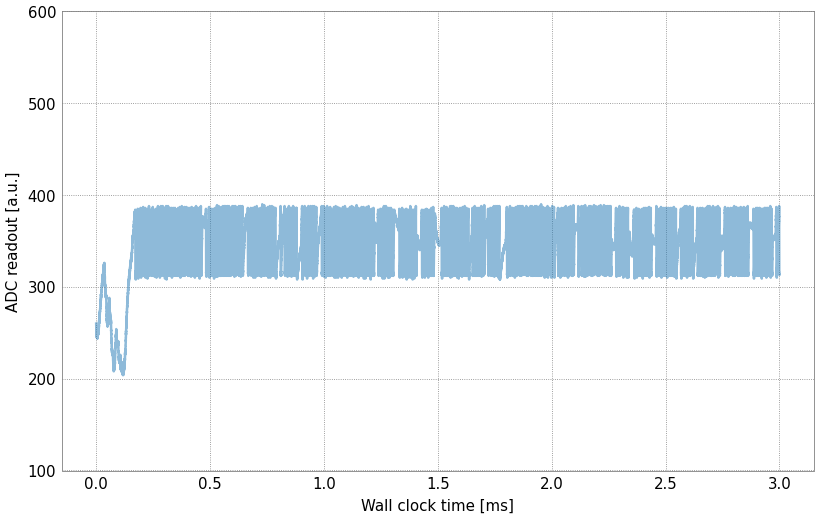

In [ ]:
# Membrane plot

plot_membrane_dynamics(p_view, ylim=(100, 600))

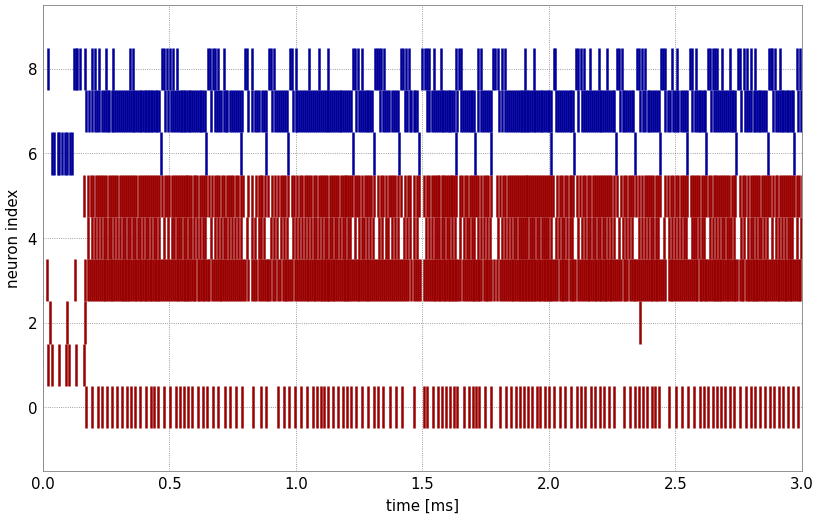

In [ ]:
# Spike plot

spiketrains = []

spikes = pop_ex1.get_data("spikes").segments[0]
for spiketrain in spikes.spiketrains:
    spiketrains.append(spiketrain.base)

spikes = pop_ex2.get_data("spikes").segments[0]
for spiketrain in spikes.spiketrains:
    spiketrains.append(spiketrain.base)

spikes = pop_inhib1.get_data("spikes").segments[0]
for spiketrain in spikes.spiketrains:
    spiketrains.append(spiketrain.base)

fig = plt.gcf()
plt.eventplot(spiketrains, color=['#990000']*6 + ['#000099']*3)
plt.xlim(0, runtime)
plt.xlabel("time [ms]")
plt.ylabel("neuron index")
fig.show()